In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, RocCurveDisplay

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)


--- LOJİSTİK REGRESYON PİPELİNE BAŞLATILDI ---
log_model.intercept_ = -1.1103
log_model.coef_ = 
[[-0.18992439  0.31869377  0.07923061 -0.1447636   0.03149288 -0.22124355
  -0.56148682  0.21190765 -0.05751303  1.36364014 -1.57216341 -1.41321542
  -1.11238342 -0.47861881 -0.5065899   0.83444544  1.33410764 -1.018595
   1.60480666  0.12016744  0.44118095  0.57572922 -1.40948517  1.35246059]]

[Öznitelik Katsayıları]:
                       Feature  Coefficient
18                 FastingBS_1        1.605
9                        Sex_M        1.364
23    Cholesterol_Is_Missing_1        1.352
16               ST_Slope_Flat        1.334
15            ExerciseAngina_Y        0.834
21  AgeGroup_Optimized_Senior+        0.576
20   AgeGroup_Optimized_Middle        0.441
1                    RestingBP        0.319
7                HR_Efficiency        0.212
19                  HighChol_1        0.120
2                  Cholesterol        0.079
4                      Oldpeak        0.031
8        

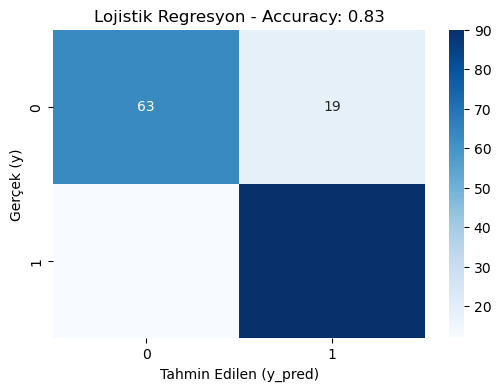


[Classification Report]:
              precision    recall  f1-score   support

           0       0.84      0.77      0.80        82
           1       0.83      0.88      0.85       102

    accuracy                           0.83       184
   macro avg       0.83      0.83      0.83       184
weighted avg       0.83      0.83      0.83       184



<Figure size 800x600 with 0 Axes>

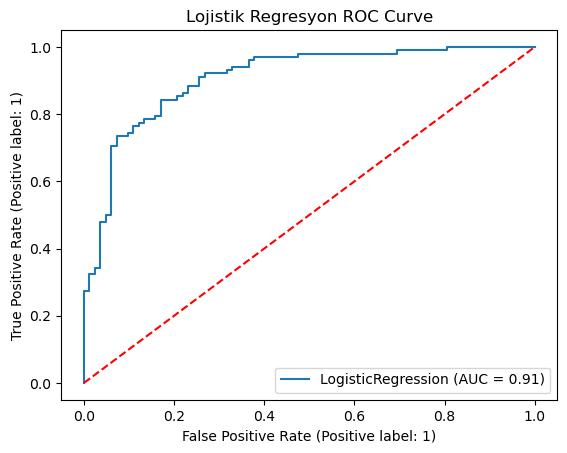

ROC AUC Score: 0.9072

--- 5-Fold Cross Validation Başlatılıyor ---
CV Accuracy: 0.8705
CV Precision: 0.8740
CV Recall: 0.8940
CV F1-score: 0.8834
CV ROC AUC: 0.9340

Rastgele Seçilen Gözlem Tahmini: SAĞLIKLI


In [10]:
# ==========================================================
# MODÜL 1: DEĞİŞKEN AYRIŞTIRMA (grab_col_names)
# ==========================================================
def grab_col_names(dataframe, cat_th=10, car_th=20):
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]
    return cat_cols, num_cols, cat_but_car

# ==========================================================
# MODÜL 2: ÖZELLİK MÜHENDİSLİĞİ (create_new_features)
# ==========================================================
def create_new_features(df):
    df_new = df.copy()
    
    # 1. Klinik Skorlar ve Etkileşimler
    df_new['RPP'] = (df_new['RestingBP'] * df_new['MaxHR']) / 100
    
    # ExerciseAngina'yı sayısal işleme hazırlama
    angina_map = {'Y': 1, 'N': 0}
    
    # DTS: Duke Treadmill Score Simülasyonu
    df_new['DTS_Simulated'] = 1 - (5 * df_new['Oldpeak']) - (4 * df_new['ExerciseAngina'].map(angina_map))
    
    df_new['HR_Efficiency'] = df_new['MaxHR'] / (220 - df_new['Age'])
    df_new['Age_Oldpeak'] = df_new['Age'] * df_new['Oldpeak']

    # 2. Risk Grupları ve Kategorizasyon
    df_new['HighChol'] = (df_new['Cholesterol'] > 200).astype(int)
    
    # AgeGroup_Optimized: Yaşa dayalı risk segmentasyonu
    df_new['AgeGroup_Optimized'] = pd.cut(
        df_new['Age'], 
        bins=[0, 45, 55, 120], 
        labels=['Young', 'Middle', 'Senior+']
    )
    
    df_new['MetabolicRisk'] = ((df_new['FastingBS'] == 1) & (df_new['HighChol'] == 1)).astype(int)
    
    return df_new

# ==========================================================
# MODÜL 3: VERİ ÖN İŞLEME (Preprocessing & Leakage Protection)
# ==========================================================
def heart_data_prep(X_train, X_test):
    # Train ve Test kopyaları üzerinden işlem yapma
    X_train_prep = X_train.copy()
    X_test_prep = X_test.copy()

    # 1. Hatalı/Eksik Veri İşaretleme
    for df in [X_train_prep, X_test_prep]:
        # Kolesterol 0 değerlerini NaN yap
        df['Cholesterol_Is_Missing'] = (df['Cholesterol'] == 0).astype(int)
        df['Cholesterol'] = df['Cholesterol'].replace(0, np.nan)
        # Kan Basıncı 0 değerlerini NaN yap
        df['RestingBP'] = df['RestingBP'].replace(0, np.nan)

    # 2. Sızıntısız Doldurma (Imputation)
    # Sadece TRAIN setinden istatistikleri alıyoruz
    chol_medians = X_train_prep.groupby('Sex')['Cholesterol'].median()
    bp_median = X_train_prep['RestingBP'].median()

    # Train ve Test setlerini Train'den gelen bilgiyle doldurma
    for gender in ['M', 'F']:
        X_train_prep.loc[(X_train_prep['Sex'] == gender) & (X_train_prep['Cholesterol'].isna()), 'Cholesterol'] = chol_medians[gender]
        X_test_prep.loc[(X_test_prep['Sex'] == gender) & (X_test_prep['Cholesterol'].isna()), 'Cholesterol'] = chol_medians[gender]

    X_train_prep['RestingBP'] = X_train_prep['RestingBP'].fillna(bp_median)
    X_test_prep['RestingBP'] = X_test_prep['RestingBP'].fillna(bp_median)

    # 3. Encoding İşlemi
    # Önce kolonları belirle
    cat_cols, num_cols, cat_but_car = grab_col_names(X_train_prep)
    
    # One-Hot Encoding (Dummies)
    X_train_prep = pd.get_dummies(X_train_prep, columns=cat_cols, drop_first=True)
    X_test_prep = pd.get_dummies(X_test_prep, columns=cat_cols, drop_first=True)

    # Kolon eşitleme (Train'de olup Test'te olmayan kolonları 0 ile doldur)
    X_test_prep = X_test_prep.reindex(columns=X_train_prep.columns, fill_value=0)

    return X_train_prep, X_test_prep

# ==========================================================
# MODÜL 4: FINAL PIPELINE
# ==========================================================
def run_logistic_pipeline(df, target="HeartDisease"):
    print("--- LOJİSTİK REGRESYON PİPELİNE BAŞLATILDI ---")
    
    # 1. Özellik Mühendisliği
    df_enriched = create_new_features(df)
    
    # 2. Train-Test Ayırma
    y = df_enriched[target]
    X = df_enriched.drop(target, axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=17)
    
    # 3. Ön İşleme (Sızıntı Korumalı)
    X_train_prep, X_test_prep = heart_data_prep(X_train, X_test)
    
    # 4. Standartlaştırma (Lojistik Regresyon için ZORUNLUDUR)
    num_cols = X_train_prep.select_dtypes(include=['float64', 'int64']).columns
    scaler = StandardScaler()
    X_train_prep[num_cols] = scaler.fit_transform(X_train_prep[num_cols])
    X_test_prep[num_cols] = scaler.transform(X_test_prep[num_cols])
    
    # 5. Model Eğitimi
    log_model = LogisticRegression().fit(X_train_prep, y_train)
    # Katsayıları formatlı şekilde yazdırma
    print(f"log_model.intercept_ = {log_model.intercept_[0]:.4f}")
    print(f"log_model.coef_ = \n{log_model.coef_}")
    # Hangi katsayının hangi değişkene ait olduğunu görmek için:
    feature_coefficients = pd.DataFrame({'Feature': X_train_prep.columns, 
                                     'Coefficient': log_model.coef_[0]})
    print("\n[Öznitelik Katsayıları]:")
    print(feature_coefficients.sort_values(by="Coefficient", ascending=False))
    
    # 6. Tahminler
    y_pred = log_model.predict(X_test_prep)
    y_prob = log_model.predict_proba(X_test_prep)[:, 1]
    
    # ------------------------------------------------------
    # MODEL EVALUATION (DEĞERLENDİRME)
    # ------------------------------------------------------
    
    # A. Karmaşıklık Matrisi (Confusion Matrix)
    acc = round(accuracy_score(y_test, y_pred), 2)
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt=".0f", cmap="Blues")
    plt.xlabel('Tahmin Edilen (y_pred)')
    plt.ylabel('Gerçek (y)')
    plt.title(f'Lojistik Regresyon - Accuracy: {acc}')
    plt.show()

    # B. Sınıflandırma Raporu
    print("\n[Classification Report]:")
    print(classification_report(y_test, y_pred))

    # C. ROC Curve Görselleştirme (plot_roc_curve hatası giderildi)
    plt.figure(figsize=(8, 6))
    RocCurveDisplay.from_estimator(log_model, X_test_prep, y_test)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.title('Lojistik Regresyon ROC Curve')
    plt.show()

    # D. ROC AUC Skoru
    auc_score = roc_auc_score(y_test, y_prob)
    print(f"ROC AUC Score: {auc_score:.4f}")

    # ------------------------------------------------------
    # MODEL VALIDATION: 10-Fold Cross Validation
    # ------------------------------------------------------
    print("\n--- 5-Fold Cross Validation Başlatılıyor ---")
    # NOT: CV tüm veri üzerinde yapılır, ancak sızıntı olmaması için 
    # burada train_prep üzerinden simüle ediyoruz.
    cv_results = cross_validate(log_model, X_train_prep, y_train, cv=5,
                                 scoring=["accuracy", "precision", "recall", "f1", "roc_auc"])
    
    print(f"CV Accuracy: {cv_results['test_accuracy'].mean():.4f}")
    print(f"CV Precision: {cv_results['test_precision'].mean():.4f}")
    print(f"CV Recall: {cv_results['test_recall'].mean():.4f}")
    print(f"CV F1-score: {cv_results['test_f1'].mean():.4f}")
    print(f"CV ROC AUC: {cv_results['test_roc_auc'].mean():.4f}")

    # ------------------------------------------------------
    # RASTGELE GÖZLEM TAHMİNİ
    # ------------------------------------------------------
    random_user = X_test_prep.sample(1, random_state=45)
    prediction = log_model.predict(random_user)
    print(f"\nRastgele Seçilen Gözlem Tahmini: {'HASTA' if prediction[0]==1 else 'SAĞLIKLI'}")
    
    return log_model

# ÇALIŞTIRMA:
def load():
    data = pd.read_csv("dataset/heart.csv")
    return data
df = load()
final_model = run_logistic_pipeline(df)